# Custom MFCC Implementation:
Author: David Schulz

In [ ]:
import numpy as np
from librosa import load, feature, ex, display

In [16]:
def extract_mfcc_feature(
    y: np.array, 
    fs: float, 
    n_fft: int = 512, 
    frame_size: float = 0.025, 
    frame_step: float = 0.01,
    n_mels: int = 40, 
    n_mfcc: int = 13
):

    mag_spec_frames = np.abs(stft(y, fs, n_fft, frame_size, frame_step))

    pow_spec_frames = (mag_spec_frames**2) / mag_spec_frames.shape[1]

    mel_power_spec_frames, hz_freq = mel_filter(pow_spec_frames, 0, fs/2, n_mels, fs)

    log_spec_frames = signal_power_to_db(mel_power_spec_frames)

    mfcc = discrete_cos_transformation(log_spec_frames)

    mfcc = sin_liftering(mfcc)

    mfcc = mfcc[:, 1:n_mfcc]

    return mfcc

In [17]:
def framing(signal: np.array, fs: float, frame_size: float, frame_step: float):
    frame_length = np.round(frame_size * fs).astype(int)
    frame_step = np.round(frame_step * fs).astype(int)
    signal_length = signal.shape[0]

    n_frames = np.ceil(abs(signal_length - frame_length) / frame_step).astype(int)

    pad_signal_length = int(n_frames * frame_step + frame_length)
    zeros_pad = np.zeros((1, pad_signal_length - signal_length))
    pad_signal = np.concatenate((signal.reshape((1, -1)), zeros_pad), axis=1).reshape(-1)

    frames = np.zeros((n_frames, frame_length))
    indices = np.arange(0, frame_length)

    for i in np.arange(0, n_frames):
        offset = i * frame_step
        frames[i] = pad_signal[(indices + offset)]

    return frames


def hamming(frames: np.array):
    window_length = frames.shape[1]
    n = np.arange(0, window_length)

    h = 0.54 - 0.46 * np.cos(2 * np.pi * n / (window_length - 1))

    frames *= h

    return frames


def stft(y: np.array, fs: float, n_fft: int, frame_size: float, frame_step: float):
    frames = framing(y, fs, frame_size, frame_step)

    frames = hamming(frames)

    spec_frames = np.fft.fft(frames, n=n_fft, axis=1)

    spec_frames = spec_frames[:, 0: int(n_fft / 2 + 1)]

    return spec_frames


def mel_filter(frames, f_min, f_max, n_mels, fs):

    n_fft = frames.shape[1] - 1

    mel_lf = 2595 * np.log10(1 + f_min / 700)
    mel_hf = 2595 * np.log10(1 + f_max / 700)

    mel_points = np.linspace(mel_lf, mel_hf, n_mels + 2)

    hz_points = 700 * (np.power(10, mel_points / 2595) - 1)

    fft_bank_bin = np.floor((n_fft + 1) * hz_points / (fs / 2))
    fft_bank_bin[-1] = n_fft

    f_bank = np.zeros((n_mels, n_fft + 1))
    for i in np.arange(1, n_mels + 1):
        left_f = int(fft_bank_bin[i - 1])
        center_f = int(fft_bank_bin[i])
        right_f = int(fft_bank_bin[i + 1])

        for k in np.arange(left_f, center_f + 1):
            f_bank[i - 1, k] = (k - left_f) / (center_f - left_f)

        for k in np.arange(center_f, right_f + 1):
            f_bank[i - 1, k] = (-k + right_f) / (-center_f + right_f)

        f_bank[i - 1] /= (hz_points[i] - hz_points[i-1])

    filtered_frames = np.dot(frames, f_bank.T)

    filtered_frames += np.finfo(float).eps

    return filtered_frames, hz_points


def signal_power_to_db(power_frames, min_amp=1e-10, top_db=80):
    log_spec = 10.0 * np.log10(np.maximum(min_amp, power_frames))
    log_spec = np.maximum(log_spec, log_spec.max() - top_db)

    return log_spec


def discrete_cos_transformation(frames: np.array):
    rows, cols = frames.shape

    N = cols
    n = np.arange(1, N + 1)

    weights = np.zeros((N, N))
    for k in np.arange(0, N):
        weights[:, k] = np.cos(np.pi * (n - 1 / 2) * k / N)

    dct_signal = np.sqrt(2 / N) * np.dot(frames, weights)

    return dct_signal


def sin_liftering(mfcc: np.array):
    mfcc_lift = np.zeros(mfcc.shape)

    n = np.arange(1, mfcc_lift.shape[1] + 1)
    D = 22
    w = 1 + (D / 2) * np.sin(np.pi * n / D)

    mfcc_lift = mfcc * w

    return mfcc_lift

In [23]:
y, sr = load(ex('libri1'))

In [45]:
mfccs = extract_mfcc_feature(y,sr)

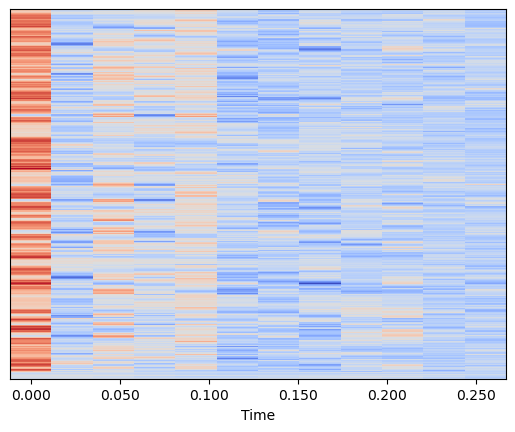

In [35]:
display.specshow(mfccs, x_axis='time')

In [47]:
mfccs2 = feature.mfcc(y=y, sr=sr, n_mfcc=40)

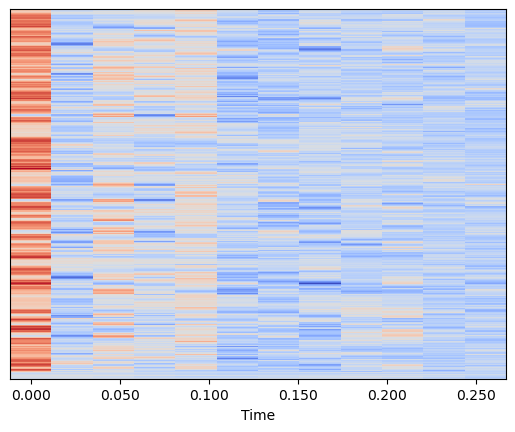

In [38]:
display.specshow(mfccs, x_axis='time')